In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime
import matplotlib.pyplot as plt

In [2]:
import uqer
from uqer import DataAPI   #优矿api
client = uqer.Client(token='18266a7c0ac9f8cdbe00f9b2ecb65f42316a5f78d9cc22ebabcbd923593356e4')

127807@wmcloud.com 账号登录成功


In [19]:

#outData = pd.DataFrame()
#for tempticker in data.ticker.unique():
#    print(tempticker)
outData = DataAPI.MktEqudGet(ticker='000001', beginDate='2017-01-03', endDate='2022-06-01', pandas="1")
outData = outData[['ticker', 'tradeDate', 'openPrice', 'highestPrice', 'lowestPrice', 'closePrice', 'turnoverVol']]
outData['tradeDate'] = pd.to_datetime(outData['tradeDate'], format = '%Y-%m-%d')
outData = outData.set_index(['ticker', 'tradeDate'])
#    outData = outData.append(temp_outData)
outData.head(3).append(outData.tail(3))

/workspace1/liufengyuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


openPrice  highestPrice  lowestPrice  closePrice  \
ticker tradeDate                                                      
000001 2017-01-03       9.11          9.18         9.09        9.16   
       2017-01-04       9.15          9.18         9.14        9.16   
       2017-01-05       9.17          9.18         9.15        9.17   
       2022-05-30      14.26         14.28        14.04       14.08   
       2022-05-31      14.07         14.18        14.00       14.16   
       2022-06-01      14.14         14.14        14.00       14.08   

                   turnoverVol  
ticker tradeDate                
000001 2017-01-03     45984049  
       2017-01-04     44932953  
       2017-01-05     34437291  
       2022-05-30     89690123  
       2022-05-31     93886855  
       2022-06-01     84529898

In [4]:
def getDailyVol(close, span0 = 22):
    #daily vol, reindexed to close
    close['return'] = close.groupby(['ticker'])['closePrice'].apply(lambda x: x/x.shift(1) - 1)
    # 22 days, a month EWM's std as boundary
    outData['Volatility'] = close.groupby(['ticker'])['return'].apply(lambda x: x.ewm(span=span0).std())

In [20]:
getDailyVol(outData)
outData

openPrice  highestPrice  lowestPrice  closePrice  \
ticker tradeDate                                                      
000001 2017-01-03       9.11          9.18         9.09        9.16   
       2017-01-04       9.15          9.18         9.14        9.16   
       2017-01-05       9.17          9.18         9.15        9.17   
       2017-01-06       9.17          9.17         9.11        9.13   
       2017-01-09       9.13          9.17         9.11        9.15   
...                      ...           ...          ...         ...   
       2022-05-26      14.41         14.43        14.07       14.19   
       2022-05-27      14.29         14.35        14.11       14.18   
       2022-05-30      14.26         14.28        14.04       14.08   
       2022-05-31      14.07         14.18        14.00       14.16   
       2022-06-01      14.14         14.14        14.00       14.08   

                   turnoverVol    return  Volatility  
ticker tradeDate                                      
000001 2017-01-03     45984049       NaN         NaN  
       2017-01-04     44932953  0.000000         NaN  
       2017-01-05     34437291  0.001092    0.000772  
       2017-01-06     35815420 -0.004362    0.002959  
       2017-01-09     36108157  0.002191    0.002958  
...                        ...       ...         ...  
       2022-05-26    101131756 -0.013899    0.020945  
       2022-05-27     72306674 -0.000705    0.020034  
       2022-05-30     89690123 -0.007052    0.019169  
       2022-05-31     93886855  0.005682    0.018524  
       2022-06-01     84529898 -0.005650    0.017716  

[1314 rows x 7 columns]

In [65]:
def Triple_Barriers(df, width): # [3:1]

    # get result Dataframe pd.Timedelta(days = 15)
    result = df[['closePrice', 'Volatility']].copy(deep = True) # index: (ticker, tradeDate); columns: closePrice, Volatility
    result[['TB', 'UB', 'LB']] = np.nan

    # deal with each stock
    for tempticker in result.index.get_level_values('ticker').unique():

        # get the barrier of each stock
        print(tempticker)
        df_temp = result.loc[tempticker]
        # set time boundary, upper boundary, or lower boundary
        for date, price, vol in df_temp[['closePrice', 'Volatility']].itertuples():

            # set the time boundary 
            time_span = 10
            d_index = len(df_temp.loc[df_temp.index[0] : date])
            if (d_index + time_span < len(df_temp.index) and time_span != 0):
                T_Barrier = df_temp.index[d_index + time_span]
            #result.loc[(result.tradeDate==date) & (result.ticker==tempticker), 'TB'] = date + pd.Timedelta(days = time_span)
            
            # set the upperbound
            if width[0] > 0: 
                U_Barrier = price*(1 + width[0]*vol)
                #result.loc[(result.tradeDate==date) & (result.ticker==tempticker), 'UB'] = price*(1 + width[0]*vol)

            # set the lowerbound
            if width[1] > 0: 
                L_Barrier = price*(1 - width[0]*vol)
                #result.loc[(result.tradeDate==date) & (result.ticker==tempticker), 'LB'] = price*(1 - width[1]*vol)

            result.loc[(tempticker, date), ['TB', 'UB', 'LB']] = T_Barrier, U_Barrier, L_Barrier

            """
            # get the time interval between the begin date (tradeDate) and the time bound
            df0 = df[(df['tradeDate'] > date) & (df['tradeDate'] < tb)].copy(deep=True)

            # get the return of each tradeDate relative to the begin date
            df0['Return'] = df0['closePrice'] / df[df.tradeDate == date]['closePrice'].iloc[0] - 1

            # index of the begin date and ticker
            idx = result.index[(result.tradeDate==date) & (result.ticker==tempticker)]
            
            # get the first time the stock touch the bounds
            result.loc[idx,'ut'] = df0[df0['Return']>barrier[barrier.tradeDate==date]['UB'].iloc[0]]['tradeDate'].min()
            result.loc[idx,'lt'] = df0[df0['Return']<barrier[barrier.tradeDate==date]['LB'].iloc[0]]['tradeDate'].min()
            """
    return result[['closePrice', 'TB', 'UB', 'LB']]

In [116]:
lower_B = 2
upper_B = 3*lower_B

In [117]:
result = Triple_Barriers(outData, [upper_B, lower_B])
result

000001


closePrice                   TB         UB         LB
ticker tradeDate                                                        
000001 2017-01-03        9.16  2017-01-18 00:00:00        NaN        NaN
       2017-01-04        9.16  2017-01-19 00:00:00        NaN        NaN
       2017-01-05        9.17  2017-01-20 00:00:00   9.212473   9.127527
       2017-01-06        9.13  2017-01-23 00:00:00   9.292114   8.967886
       2017-01-09        9.15  2017-01-24 00:00:00   9.312404   8.987596
...                       ...                  ...        ...        ...
       2022-05-26       14.19  2022-06-01 00:00:00  15.973228  12.406772
       2022-05-27       14.18  2022-06-01 00:00:00  15.884508  12.475492
       2022-05-30       14.08  2022-06-01 00:00:00  15.699415  12.460585
       2022-05-31       14.16  2022-06-01 00:00:00  15.733803  12.586197
       2022-06-01       14.08  2022-06-01 00:00:00  15.576650  12.583350

[1314 rows x 4 columns]

In [113]:
def get_label():
    result['label'] = np.nan

    # deal with each stock
    for tempticker in result.index.get_level_values('ticker').unique():

        # get the barrier of each stock
        print(tempticker)
        df_temp = result.loc[tempticker]
        # set time boundary, upper boundary, or lower boundary
        for index in range(len(df_temp.index)):
            begin_day = df_temp.index[index]
            end_day = df_temp.TB[index]

            if pd.notna(end_day):
                begin_price = df_temp.closePrice[begin_day]
                end_price = df_temp.closePrice[end_day]

                UB = df_temp.UB[begin_day]
                LB = df_temp.LB[begin_day]

                PT_condition = (df_temp.closePrice[begin_day:end_day] >= UB).any()
                SL_condition = (df_temp.closePrice[begin_day:end_day] <= LB).any()

                if PT_condition and SL_condition:
                    profit_taking_index = df_temp[begin_day:end_day][df_temp.closePrice[begin_day:end_day] >= UB].index.min()
                    stop_loss_index = df_temp[begin_day:end_day][df_temp.closePrice[begin_day:end_day] <= LB].index.min()
                    if profit_taking_index < stop_loss_index:
                        result.loc[(tempticker, begin_day), 'label'] = 1
                    else:
                        result.loc[(tempticker, begin_day), 'label'] = -1
                elif PT_condition:
                    result.loc[(tempticker, begin_day), 'label'] = 1
                elif SL_condition:
                    result.loc[(tempticker, begin_day), 'label'] = -1
                else:
                    price_diff = end_price - begin_price
                    if price_diff >= 0:
                        result.loc[(tempticker, begin_day), 'label'] = price_diff/(UB - begin_price)
                    else:
                        result.loc[(tempticker, begin_day), 'label'] = price_diff/(begin_price - LB)

In [118]:
get_label()
result

000001


closePrice                   TB         UB         LB  \
ticker tradeDate                                                           
000001 2017-01-03        9.16  2017-01-18 00:00:00        NaN        NaN   
       2017-01-04        9.16  2017-01-19 00:00:00        NaN        NaN   
       2017-01-05        9.17  2017-01-20 00:00:00   9.212473   9.127527   
       2017-01-06        9.13  2017-01-23 00:00:00   9.292114   8.967886   
       2017-01-09        9.15  2017-01-24 00:00:00   9.312404   8.987596   
...                       ...                  ...        ...        ...   
       2022-05-26       14.19  2022-06-01 00:00:00  15.973228  12.406772   
       2022-05-27       14.18  2022-06-01 00:00:00  15.884508  12.475492   
       2022-05-30       14.08  2022-06-01 00:00:00  15.699415  12.460585   
       2022-05-31       14.16  2022-06-01 00:00:00  15.733803  12.586197   
       2022-06-01       14.08  2022-06-01 00:00:00  15.576650  12.583350   

                      label  
ticker tradeDate             
000001 2017-01-03       NaN  
       2017-01-04       NaN  
       2017-01-05  1.000000  
       2017-01-06  0.555166  
       2017-01-09  0.738897  
...                     ...  
       2022-05-26 -0.061686  
       2022-05-27 -0.058668  
       2022-05-30  0.000000  
       2022-05-31 -0.050832  
       2022-06-01  0.000000  

[1314 rows x 5 columns]

In [123]:
result.label.value_counts()

 1.000000    150
-1.000000     81
 0.000000      7
-0.144975      1
 0.139237      1
            ... 
-0.069744      1
-0.570518      1
-0.152340      1
 0.589398      1
-0.145373      1
Name: label, Length: 1077, dtype: int64

In [129]:
result.loc['000001'].label

tradeDate
2017-01-03         NaN
2017-01-04         NaN
2017-01-05    1.000000
2017-01-06    0.555166
2017-01-09    0.738897
                ...   
2022-05-26   -0.061686
2022-05-27   -0.058668
2022-05-30    0.000000
2022-05-31   -0.050832
2022-06-01    0.000000
Name: label, Length: 1314, dtype: float64

In [128]:
result.label['000001']

tradeDate
2017-01-03         NaN
2017-01-04         NaN
2017-01-05    1.000000
2017-01-06    0.555166
2017-01-09    0.738897
                ...   
2022-05-26   -0.061686
2022-05-27   -0.058668
2022-05-30    0.000000
2022-05-31   -0.050832
2022-06-01    0.000000
Name: label, Length: 1314, dtype: float64

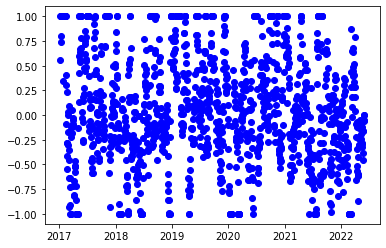

In [130]:
plt.plot(result.loc['000001'].label,'bo')

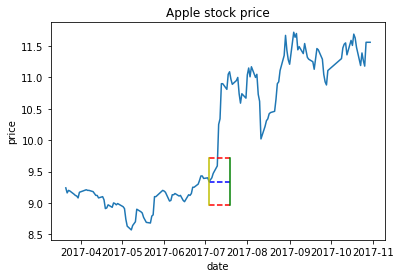

In [140]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price', xlabel='date', ylabel='price')
ax.plot(result.loc['000001'].closePrice[50: 200])

start = result.loc['000001'].index[120]
end = result.loc['000001'].TB[120]
upper_barrier = result.loc['000001'].UB[120]
lower_barrier = result.loc['000001'].LB[120]

ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'b--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'y-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'g-');

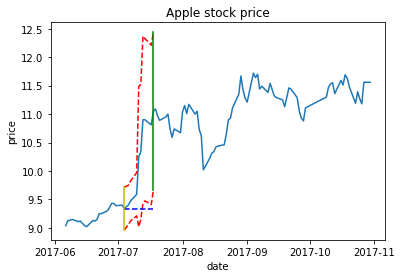

In [142]:
fig,ax = plt.subplots()
ax.set(title='Apple stock price',
       xlabel='date', ylabel='price')
ax.plot(result.loc['000001'].closePrice[100: 200])

start = result.loc['000001'].index[120]
end = result.loc['000001'].index[120+10]
upper_barrier = result.loc['000001'].UB[120]
lower_barrier = result.loc['000001'].LB[120]

ax.plot(result.loc['000001'].index[120:120+10+1], result.loc['000001'].UB[start:end], 'r--');
ax.plot(result.loc['000001'].index[120:120+10+1], result.loc['000001'].LB[start:end], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, (lower_barrier + upper_barrier)*0.5], 'b--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'y-');
ax.plot([end, end], [result.loc['000001'].LB[end], result.loc['000001'].UB[end]], 'g-');

In [41]:
def get_first_touch(df, width):
    result = Triple_Barriers(df, width)
    # choose the min time value vertically (through columns)
    result['First'] = result[['VB', 'ut', 'dt']].dropna(how='all').min(axis = 1)
    return result

In [ ]:

result = get_first_touch(result, [upper_B, lower_B])
result.head().append(result.tail())
#result.to_csv('TBML_get_first_touch.csv', index=False)

In [ ]:
def get_label(df, result):
    result = result.dropna(subset=['First'])
    outcome = result[['ticker', 'tradeDate']]

    price_t0 = pd.merge(result, df, on=['ticker', 'tradeDate'], how='left')['closePrice']
    price_t1 = pd.merge(result, df, left_on=['ticker', 'First'], right_on=['ticker', 'tradeDate'], how='left')['closePrice']

    outcome['Return'] = price_t1/price_t0 - 1
    outcome['Label'] = np.sign(outcome['Return'])

    return outcome.dropna()

In [ ]:
out = get_label(outData, result)
out.head().append(out.tail())

,tradeDate,Return,Label
0,2017-01-03,0.001092,1.0
1,2017-01-04,0.002183,1.0
2,2017-01-05,-0.004362,-1.0
3,2017-01-06,0.002191,1.0
4,2017-01-09,0.000000,0.0
1270,2022-03-25,-0.008678,-1.0
1271,2022-03-28,-0.011448,-1.0
1272,2022-03-29,0.036104,1.0
1273,2022-03-30,0.011177,1.0
1274,2022-03-31,0.024057,1.0


In [14]:
# get model
import lightgbm as lgb
model = lgb.LGBMClassifier(max_depth=5, num_leaves=10, learning_rate=0.0311, n_estimators=1748)

In [15]:
# get X and y
f_x = pickle.load(open('pct1_cal/f_x_066', 'rb'))
f_y = 'Label'

In [16]:
data['tradeDate'] = pd.to_datetime(data['tradeDate'], format = '%Y-%m-%d')

In [17]:
combined_data = data.merge(out, on=['tradeDate'], how='left')

In [18]:
combined_data['tradeDate'] = combined_data['tradeDate'].dt.strftime('%Y-%m-%d')

In [ ]:
dates = combined_data.tradeDate.sort_values().unique()
epoch_ts = list(dates)
update = 22 # 训练长度：22天
train_si = epoch_ts.index('2017-01-03') # included. '2017-01-03'
train_ei = epoch_ts.index('2019-01-02') # excluded. '2018-12-28'
test_si = epoch_ts.index('2019-01-02') # included. '2019-01-02'
test_ei = epoch_ts.index('2019-02-01') # excluded. '2019-01-31'
test_fi = len(epoch_ts) - 1 # excluded.
update_n = 0
# get a list of train dates
epoch_t_train = epoch_ts[train_si + update_n : train_ei + update_n]
# get a list of test dates
epoch_t_test = epoch_ts[test_si + update_n : test_ei + update_n]
df_train = combined_data[combined_data.tradeDate.apply(lambda x: x in epoch_t_train)].reset_index(drop=True)
df_test = combined_data[combined_data.tradeDate.apply(lambda x: x in epoch_t_test)].reset_index(drop=True)

In [ ]:
x_train = df_train[f_x].values
x_test = df_test[f_x].values
print('处理后x：', x_train.shape, x_test.shape)

y_train = df_train[f_y].copy()
y_test = df_test[f_y].copy()
print('处理后y：', y_train.shape, y_test.shape)

处理后x： (487, 290) (22, 290)
处理后y： (487,) (22,)


In [ ]:
y_train = y_train.replace(to_replace=[-1, 1], value=1)
y_test = y_test.replace(to_replace=[-1, 1], value=1)

In [ ]:
y_train.value_counts()

1.0    466
0.0     21
Name: Label, dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression( max_iter=3 )
model.fit(x_train, y_train)
#model.fit(x_train, y_train, eval_set=[(x_train,y_train), (x_test,y_test)], eval_metric='l2')

/workspace1/liufengyuan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=3)

In [ ]:
y_pred = model.predict(x_train)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

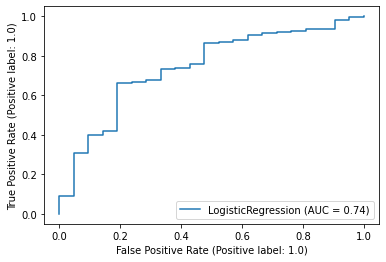

In [ ]:
plot_roc_curve(model, x_train, y_train)

In [ ]:
print( confusion_matrix(y_train, y_pred))

[[  0  21]
 [  0 466]]
